In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn
import cotengra as ctg
import quf
import numpy as np
import torch
import algo_cooling as algo
import itertools
import algo_bp
from tqdm import tqdm
import gen_loop as lg
import gen_loop_tn as lg_tn
import autoray as ar


In [2]:
opt = algo.opt_(progbar=True)
import torch
to_backend = algo.backend_torch(device = "cpu", dtype = torch.float64, requires_grad=True)
to_backend_ = algo.backend_torch(device = "cpu", dtype = torch.float64, requires_grad=False)

opt = algo.opt_(progbar=False)
# opt = "auto-hq"

In [3]:
# Define <peps | peps> as an easy problem for bp convergence:
Lx, Ly, bnd = (3, 3, 3)
L = Lx * Ly
peps = qtn.PEPS.rand(Lx=Lx, Ly=Ly, bond_dim=bnd, seed=12, dtype="float64")
fix = { f"I{i},{j}":(i,j) for i,j in itertools.product(range(peps.Lx), range(peps.Ly)) }

inds_ = { f"k{i},{j}":f"b{i},{j}"   for i in range(Lx) for j in range(Ly)}

mpo = quf.mpo_2d_His(Lx, Ly, L, data_type="float64")
pepo = quf.MPO_to_PEPO(mpo, Lx, Ly, cycle_peps= False)
pepo.show()


  ╱ 4  ╱ 8  ╱
 ●━━━━●━━━━●
╱┃1  ╱┃1  ╱┃11 
 ┃╱11 ┃╱11 ┃╱
 ●━━━━●━━━━●
╱┃11 ╱┃1  ╱┃1  
 ┃╱ 8 ┃╱ 4 ┃╱
 ●━━━━●━━━━●
╱    ╱    ╱    


In [4]:
mpo_ = quf.mpo_2d_His_(Lx,Ly,L, data_type="float64")
mpo_.show()
dmrg = qtn.DMRG2(mpo_, 
                 bond_dims=[2, 32, 64, 128, 256], 
                 cutoffs=1.e-16)
dmrg.solve(tol=1.e-14, verbosity=0, max_sweeps=20)
E_dmrg = dmrg.energy
E_dmrg / L


│4│8│11│11│11│11│8│4│
●─<─<──<──<──<──<─<─<
│ │ │  │  │  │  │ │ │


np.float64(-0.5277030287280989)

In [5]:
tn = peps.H & peps
norm = tn.contract(all, optimize=opt)
peps /= (norm**0.5)
tn = peps.H & peps
norm = tn.contract(all, optimize=opt)
print(complex(norm))

peps.apply_to_arrays(to_backend)
pepo.apply_to_arrays(to_backend)


(1.0000000000000004+0j)


In [6]:
pepsh = peps.H
pepsh.reindex_(inds_)
tn = pepsh & pepo & peps
E = tn.contract(all, optimize=opt)
E

tensor(0.1842, dtype=torch.float64, grad_fn=<MulBackward0>)

In [7]:
params, skeleton = qtn.pack(peps)
# params

In [8]:
H2 = qu.ham_heis(2) 
H2 = to_backend_(H2)
terms = {
    (coo_a, coo_b): H2
    for coo_a, coo_b in peps.gen_bond_coos()
}

In [9]:
%%time
E = peps.compute_local_expectation(
    terms,
    max_bond=None,cutoff=1e-12,
    normalized=True, contract_optimize=opt,
)
complex(E) / L

CPU times: user 26.2 ms, sys: 4.3 ms, total: 30.5 ms
Wall time: 29.4 ms


<timed exec>:6: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:837.)


(0.020467851342922817+0j)

In [10]:
peps.add_tag('KET')
pepsH = peps.conj().retag({'KET': 'BRA'})
tn = pepsH & peps


In [11]:
peps_ = peps.copy()
gauges = {}
peps_.gauge_all_simple_(20, tol=1.e-6, gauges=gauges, 
                          progbar=True, damping=0.01, 
                          equalize_norms=True,
                         )
print("exponent", peps_.exponent)
# the state normalization gives us an idea of fidelity
norm = peps_.normalize_simple(gauges)
print(norm*(10**peps_.exponent))
tn = peps_.H & peps_
norm = tn.contract(all, optimize=opt)
print(norm)


max|dS|=7.81e-07, nfact=-292.24: : 17it [00:00, 178.76it/s]

exponent tensor(6.4602, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.0712, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(2.1151e+20, dtype=torch.float64, grad_fn=<MulBackward0>)


In [12]:
Energy_l = []
for (coo_a, coo_b), G in terms.items():
    e_ = peps_.local_expectation_cluster(G, [coo_a, coo_b], normalized=True, 
                          max_distance=0, mode='graphdistance', 
                          fillin=0, grow_from='all', 
                          gauges=gauges, smudge=0.0, 
                          power=1.0, optimize=opt,
                          max_bond=None, rehearse=False)

    Energy_l.append(e_)
sum(Energy_l) / L

tensor(0.0130, dtype=torch.float64, grad_fn=<DivBackward0>)

In [13]:
def cost(params, skeleton, max_distance=0, fillin=0, update='parallel'):

    params_normed = {}
    for k, t in params.items():
        norm = ar.do("norm", t)
        params_normed[k] = t / norm
    
    peps = qtn.unpack(params_normed, skeleton)
    
    gauges = {}
    peps_ = peps.gauge_all_simple(40, tol=1.e-6, gauges=gauges, 
                              progbar=False, damping=0.01, 
                              equalize_norms=True,
                             )


    Energy_l = []
    for (coo_a, coo_b), G in terms.items():
        e_ = peps_.local_expectation_cluster(G, [coo_a, coo_b], normalized=True, 
                              max_distance=max_distance, mode='graphdistance', 
                              fillin=fillin, grow_from='all', 
                              gauges=gauges, smudge=0.0, 
                              power=1.0, optimize=opt,
                              max_bond=None, rehearse=False)
    
        Energy_l.append(e_)
    


    # print(Energy_l)
    return sum(Energy_l).real / L

def cost_(params, skeleton):
    peps = qtn.unpack(params, skeleton)
    
    # E = peps.compute_local_expectation(
    #     terms,
    #     max_bond=None,cutoff=1e-12,
    #     normalized=True, contract_optimize=opt,
    # )

    pepsh = peps.H
    pepsh.reindex_(inds_)
    tn = pepsh & pepo & peps
    E = tn.contract(all, optimize=opt)
    
    tn = peps.H & peps
    norm = tn.contract(all, optimize=opt)

    E = E / L
    return E.real / norm.real


In [14]:
cost(params, skeleton, max_distance=0, fillin=0)

tensor(0.0130, dtype=torch.float64, grad_fn=<DivBackward0>)

In [15]:
cost_(params, skeleton)

tensor(0.0205, dtype=torch.float64, grad_fn=<DivBackward0>)

In [16]:
import torch.optim as optim

optimizer = optim.Adam(params.values(), lr=0.01)
its_max = 140

loss_history = []
pbar = tqdm(total=its_max, desc="adam", ncols=100, dynamic_ncols=True)

for step in range(its_max):
    optimizer.zero_grad()
        
    loss = cost(params, skeleton, max_distance=0, fillin=0)
    loss.backward(retain_graph=False)  # keep graph if needed
    optimizer.step()
    loss_ = cost_(params, skeleton) 
    loss_history.append(loss_.item())   # store scalar for plotting
    
    #print(f"Step {step}: Loss = {loss.item()}")
    pbar.set_postfix({
            "loss": f"{loss.item():.3e}","loss_": f"{complex(loss_).real:.3e}",
        })
    pbar.update(1)
pbar.close()



adam: 100%|██████████| 140/140 [00:17<00:00,  8.04it/s, loss=-4.925e-01, loss_=-5.076e-01]


In [17]:
# import torch.optim as optim

# optimizer = optim.Adam(params.values(), lr=0.01)
# its_max = 1

# loss_history = []
# pbar = tqdm(total=its_max, desc="adam", ncols=100, dynamic_ncols=True)

# for step in range(its_max):
#     optimizer.zero_grad()
#     loss = cost_(params, skeleton)
#     loss.backward(retain_graph=True)  # keep graph if needed
#     optimizer.step()
    
#     loss_history.append(loss.item())   # store scalar for plotting
    
#     #print(f"Step {step}: Loss = {loss.item()}")
#     pbar.set_postfix({
#             "loss": f"{loss.item():.3e}",
#         })
#     pbar.update(1)
# pbar.close()



In [18]:
peps = qtn.unpack(params, skeleton)
tn = peps.H & peps
norm = tn.contract(all, optimize=opt)
norm

tensor(1953.6642, dtype=torch.float64, grad_fn=<MulBackward0>)

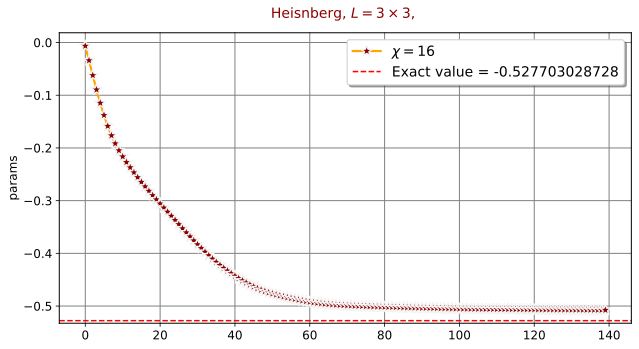

In [19]:
# Convert to CPU and detach before plotting


import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5))  # compact and clean figure



plt.plot(loss_history, zorder=5, label=r"$\chi=16$",color="orange",
    markersize=12, linewidth=2.2, alpha=1., marker='*', linestyle='-',
    markeredgecolor="whitesmoke", mfc="darkred", markeredgewidth=1.4
)

# plt.yscale('log')

# Set axis limits
# plt.xlim(0, max(t_l))        # adjust x-axis range if needed
# plt.ylim(0.99, 0.99999)            # adjust y-axis range for log scale

plt.ylabel(r"params", fontsize=12)
plt.xlabel("", fontsize=12)


-0.527703028728

plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.5)
plt.tick_params(width=0.8, labelsize=12)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.)

plt.axhline(y=-0.527703028728, color='red', linestyle='--', linewidth=1.5,
            label='Exact value = -0.527703028728')
str_ = "pepo"
plt.title(rf"Heisnberg, $L = {3} \times {3}$, ", fontsize=14, color='darkred', pad=15)  # pad adds space above the plot

plt.grid(color='gray', linestyle='-', linewidth=1., alpha=1.)
plt.legend(loc='best', frameon=True, shadow=True, fontsize=14)
plt.tight_layout()
plt.show()

